<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/Lesson02_SGD_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lesson 2**. Simple SGD(stochastic gradient descent) excercise

1.Improve Leason 1's code. Speed up the gradient descent effective.

2.Generalize leason 1's self-design DNN code.

3.Use self-implement of DNN and SGD code to train a multiple layers DNN.

4.Design a multiple-class classification excerise.

5.Compare your code with the Pytorch's implement.


In [60]:
import matplotlib.pyplot as plt
import numpy as np

def plot_features_and_labels(features, labels, size_of_class, markers, colors, title):
    plt.figure(figsize=(3,3))
    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])
    plt.title(title)
    plt.show()


def split_train_and_test_data(feature_matrix, label_matrix, split_rate = 0.9):
    m = feature_matrix.shape[0]
    split_index = int(m * split_rate)

    indices = np.array(range(m))
    np.random.shuffle(indices)

    train_indices, test_indices = np.array(indices[0:split_index]), np.array(indices[split_index:])
    train_features, train_labels = feature_matrix[train_indices, :], label_matrix[train_indices, :]
    test_features, test_labels = feature_matrix[test_indices, :], label_matrix[test_indices, :]

    return train_features, train_labels, test_features, test_labels


def draw_neuron_boundary(neuron, features, labels, markers, colors, grid_step=0.5, size_of_class= 2):
    min_x, max_x = np.min(features[:, 0]), np.max(features[:, 0])
    min_y, max_y = np.min(features[:, 1]), np.max(features[:, 1])

    xx, yy = np.meshgrid(np.arange(min_x - 1, max_x + 1, grid_step), np.arange(min_y - 1, max_y + 1, grid_step))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    predict = neuron.predict(grid_points)
    argmax_index = np.argmax(predict, axis=1)

    positive_index = grid_points[np.where(argmax_index == 0), :]
    negative_index = grid_points[np.where(argmax_index == 1), :]

    plt.figure(figsize=(4, 4))
    for i in range(size_of_class):
        class_index = grid_points[np.where(argmax_index == i), :]
        plt.scatter(class_index[0, :, 0], class_index[0, :, 1], c=colors[i], alpha=0.1)

    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])

    plt.show()

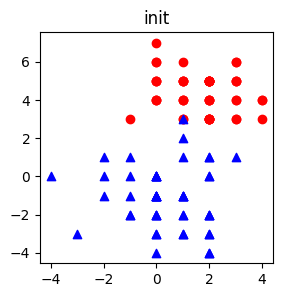

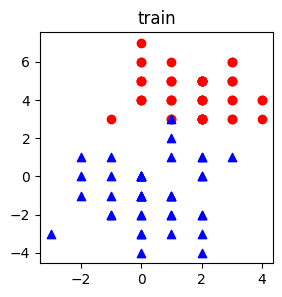

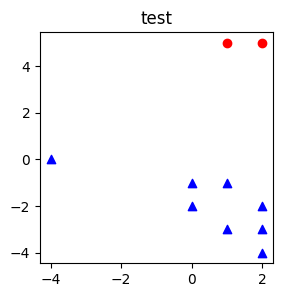

train_features shape: (90, 2)  train_labels shape: (90, 2)


In [61]:
# Generate serveral normal subsample datasets and scatter them on the figure
size_of_class = 2
size_of_sample = 50
size_of_feature = 2
means = [(2,4), (0,-1), (-2,3)]
vars = [[[1,0], [0,1]], [[2,0], [0,2]], [[3,0],[0,3]]]
#markers = ['o', '*', '^']
#colors = ['r', 'g', 'b']
markers = ['o', '^']
colors = ['r', 'b']

labels = []
features = []
for i in range(size_of_class):
    label = np.zeros((size_of_sample, size_of_class))
    label[:, i] = 1.
    feature = np.round(np.random.multivariate_normal(means[i], vars[i], size_of_sample))

    labels.append(label)
    features.append(feature)

labels = np.concatenate(labels, axis=0)
features = np.concatenate(features, axis=0)

train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')
plot_features_and_labels(test_features, test_labels, size_of_class, markers, colors, 'test')
print('train_features shape:',train_features.shape, ' train_labels shape:', train_labels.shape)

In [62]:
# Re implement simple DNN
sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))

# array / vector  very carefully
softmax = lambda a: np.exp(a) / (np.sum(np.exp(a), axis=1)[:, np.newaxis])

class Linear:
    def __init__(self, in_size, out_size = 1):
        self.in_size = in_size + 1
        self.out_size = out_size
        self.X = None
        self.W = np.random.uniform(-1., 1., size=(self.in_size, self.out_size))
        self.dL_by_dW = None

    def forward(self, X):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = self.X.dot(self.W)
        return Z

    def backward(self, dL_by_dZ):
        # Matrix Z = XW   X(m, n+1) W(n+1, out) Z(m, out)
        # dL/dZ = (m, out) dZ/dX = W.T  (out, n+1)  dZ/dW = X.T (n+1, m)
        # dL/dW = dZ/dW * dL/dZ  (n+1, out)
        # dL/dX = dL/dZ * dZ/dX  (m, n+1)

        # backward dL/dX and record dL/dW
        dZ_by_dW = self.X.T  #(n+1, m)
        dZ_by_dX = self.W.T  #(out, n+1)
        dL_by_dX = dL_by_dZ.dot(dZ_by_dX) #(m, n+1)
        self.dL_by_dW = dZ_by_dW.dot(dL_by_dZ) #(n+1, out)
        return dL_by_dX[:, :-1]

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = X.dot(self.W)
        return Z

    def update_weights(self, learning_rate):
        self.W = self.W - self.dL_by_dW * learning_rate


class Sigmoid_Active_Function:
    def __init__(self):
        self.active_function = sigmoid
        self.H = None

    def forward(self, X):
        self.H = self.active_function(X)
        return self.H

    def backward(self, up_gradient):
        self.local_gradient = (1 - self.H) * self.H
        down_gradient = up_gradient * self.local_gradient
        return down_gradient

    def predict(self, X):
        H = self.active_function(X)
        return H


class SimpleDNN:
    def __init__(self, size_of_feature, size_of_class):
        self.L1 = Linear(in_size=size_of_feature, out_size=1)
        self.A1 = Sigmoid_Active_Function()
        self.L2 = Linear(in_size=1, out_size=size_of_class)

    def forward(self, X):
        Z = self.L2.forward(self.A1.forward(self.L1.forward(X)))
        return Z

    def backward(self, E):
        dLoss_by_dL2 = self.L2.backward(E)
        dLoss_by_dA1 = self.A1.backward(dLoss_by_dL2)
        dLoss_by_dL1 = self.L1.backward(dLoss_by_dA1)
        return dLoss_by_dL1

    def predict(self, X):
        Z = self.L2.predict(self.A1.predict(self.L1.predict(X)))
        Y_hat = softmax(Z)
        return Y_hat

    def update_weights(self, learning_rate):
        self.L2.update_weights(learning_rate)
        self.L1.update_weights(learning_rate)


class Cross_Entropy_Loss:
    def __init__(self):
        self.process_function = softmax

    def forward(self, Z, Y):
        self.Y_hat = self.process_function(Z)
        self.loss = -1. * np.sum(Y * np.log(self.Y_hat, where= self.Y_hat != 0)) #KL divergence
        return self.Y_hat, self.loss

    def backward(self, Y):
        # Math provement
        self.dL_by_dZ = self.Y_hat - Y
        return self.dL_by_dZ

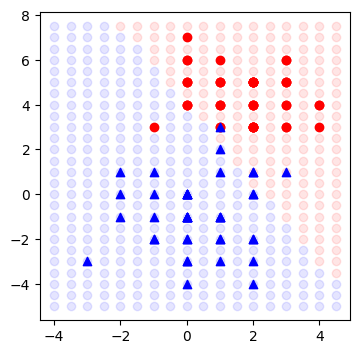

Epoch 1
-------------------------------
loss : 0.6688198875807978


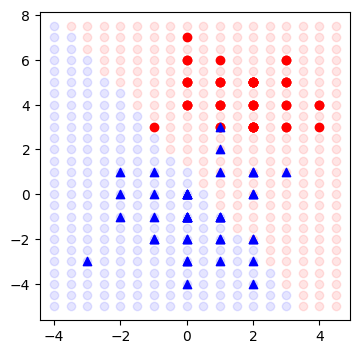

loss : 0.24319954955417875


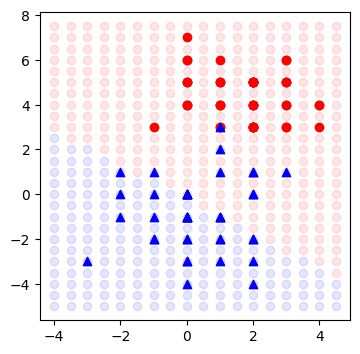

Epoch 2
-------------------------------
loss : 0.23121119130154966


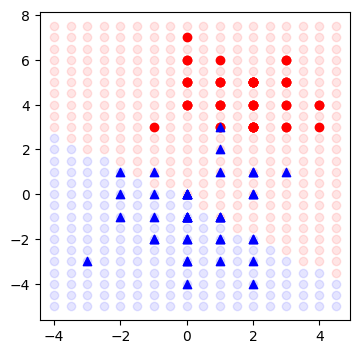

loss : 0.18057335794003757


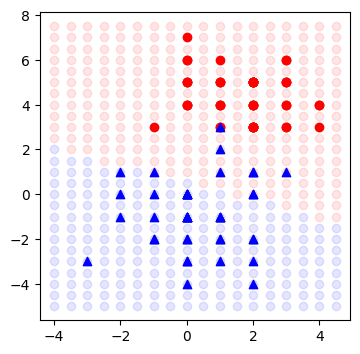

Epoch 3
-------------------------------
loss : 0.18198653588768612


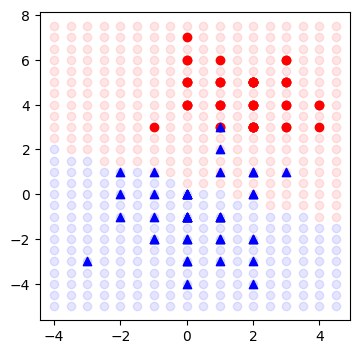

loss : 0.12761614715561762


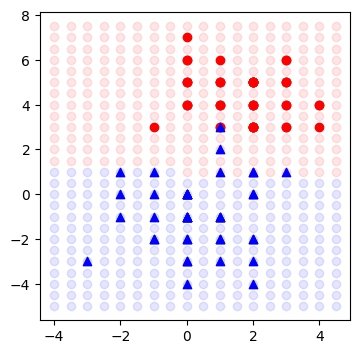

Epoch 4
-------------------------------
loss : 0.15991381499968516


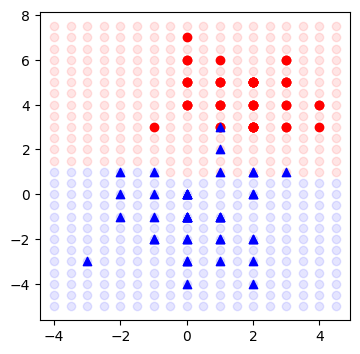

loss : 0.08824849505977087


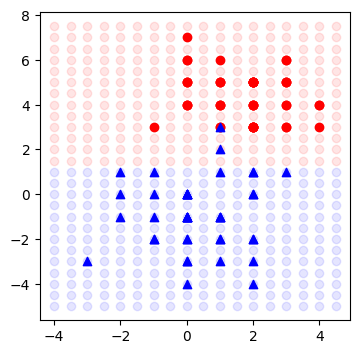

Epoch 5
-------------------------------
loss : 0.13444993405799827


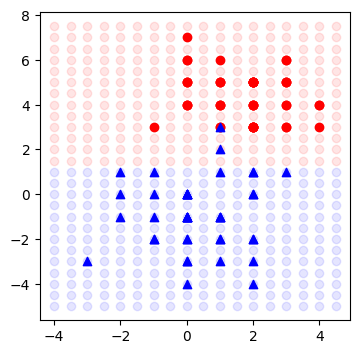

loss : 0.06746816005621271


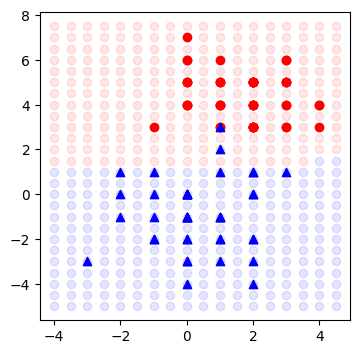

Epoch 6
-------------------------------
loss : 0.11413484526644768


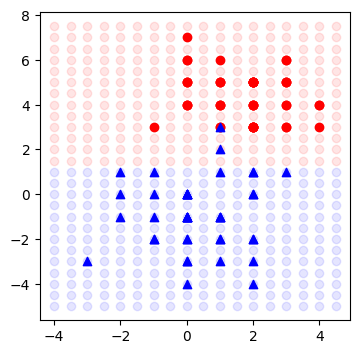

loss : 0.0545944885017248


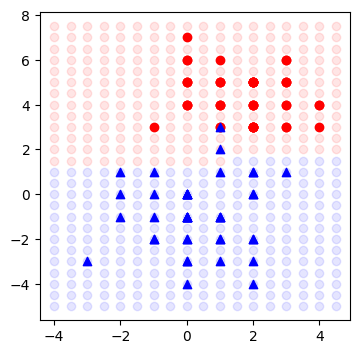

Epoch 7
-------------------------------
loss : 0.09980141824856173


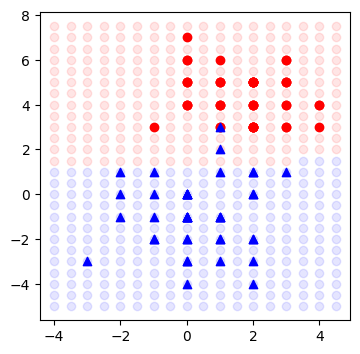

loss : 0.04576954379492013


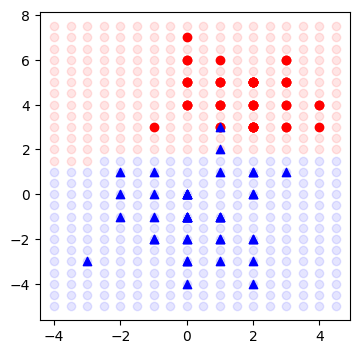

Epoch 8
-------------------------------
loss : 0.08911904021985935


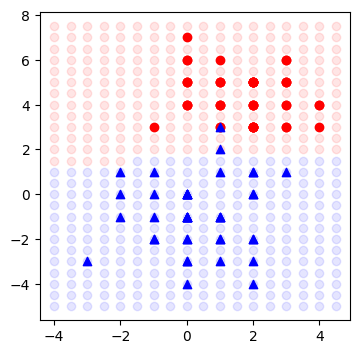

loss : 0.03941717100085848


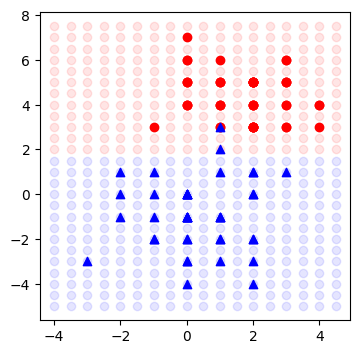

Epoch 9
-------------------------------
loss : 0.08092197335395127


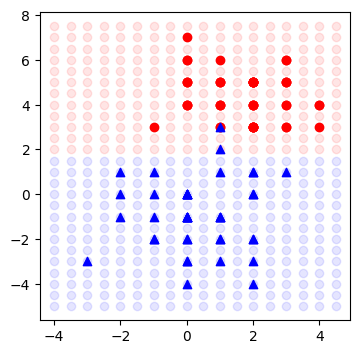

loss : 0.03467550514609311


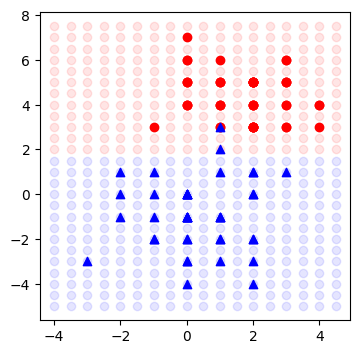

Epoch 10
-------------------------------
loss : 0.07449218505946517


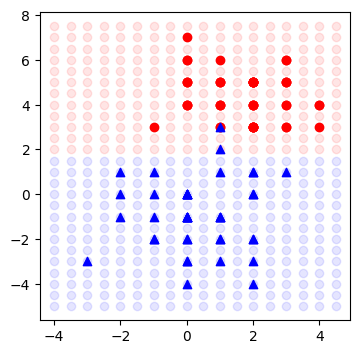

loss : 0.031024293676545408


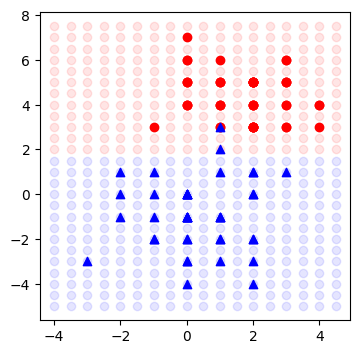

Epoch 11
-------------------------------
loss : 0.06933852987280743


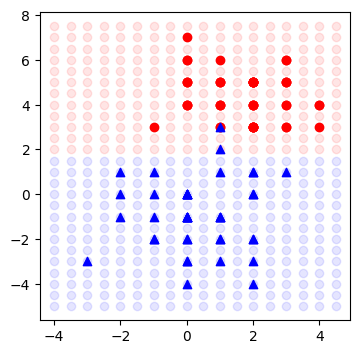

loss : 0.028136762368931593


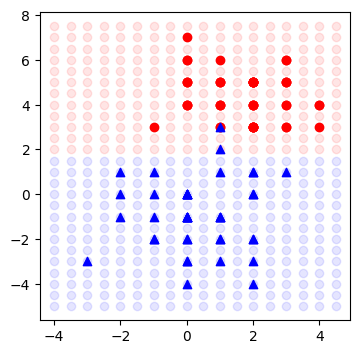

Epoch 12
-------------------------------
loss : 0.06511893204972893


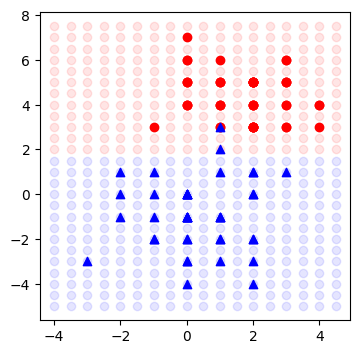

loss : 0.025801112969524493


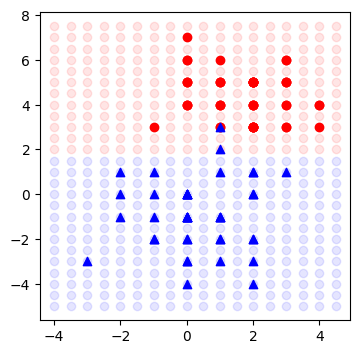

Epoch 13
-------------------------------
loss : 0.061594035840332524


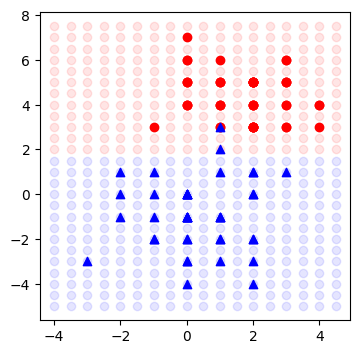

loss : 0.023875782093818285


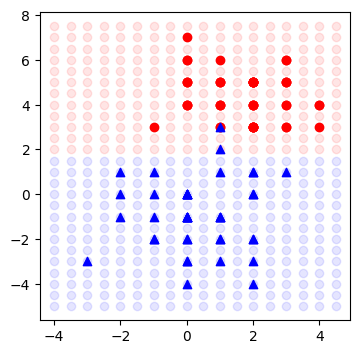

Epoch 14
-------------------------------
loss : 0.05859501581226315


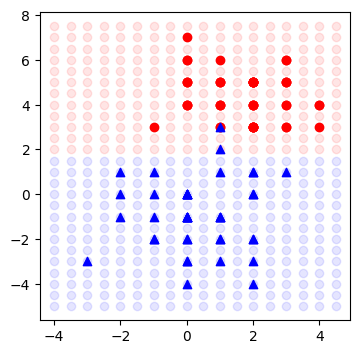

loss : 0.022263307297973184


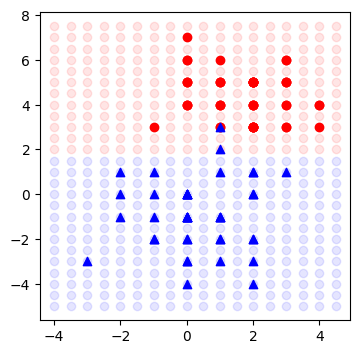

Epoch 15
-------------------------------
loss : 0.05600141453657336


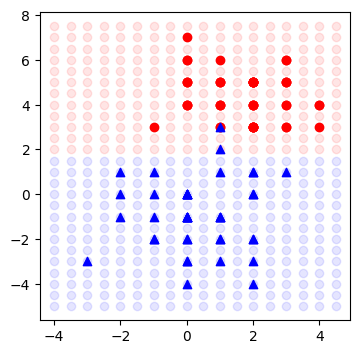

loss : 0.020894716094933895


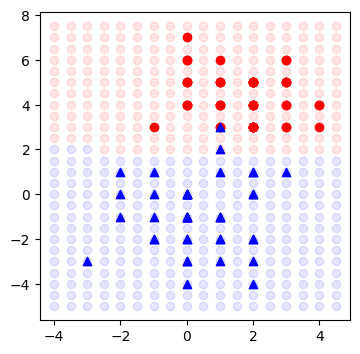

Epoch 16
-------------------------------
loss : 0.053726166832346704


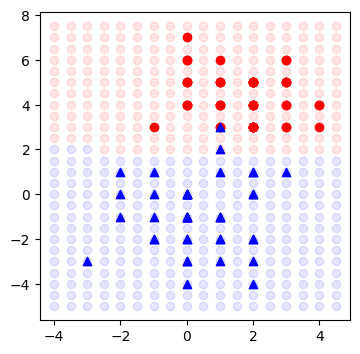

loss : 0.019719961030809422


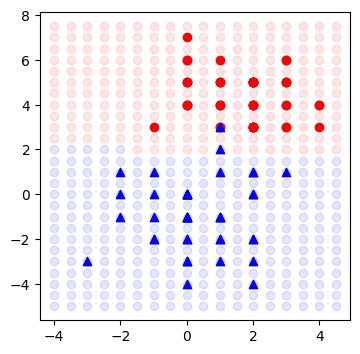

Epoch 17
-------------------------------
loss : 0.05170553103131556


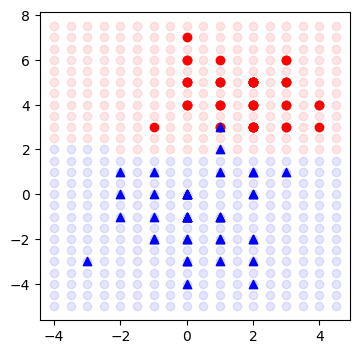

loss : 0.018701899800409854


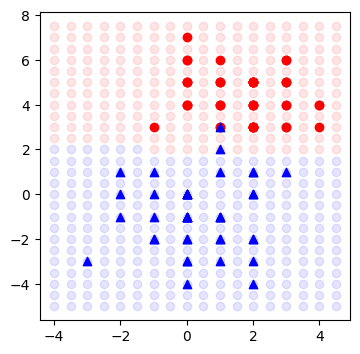

Epoch 18
-------------------------------
loss : 0.04989227607651485


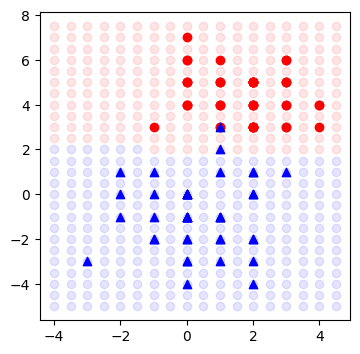

loss : 0.017812404338249682


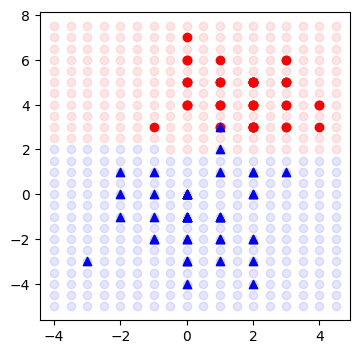

Epoch 19
-------------------------------
loss : 0.04825100939362227


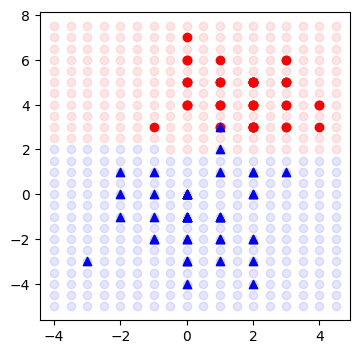

loss : 0.017029781454784437


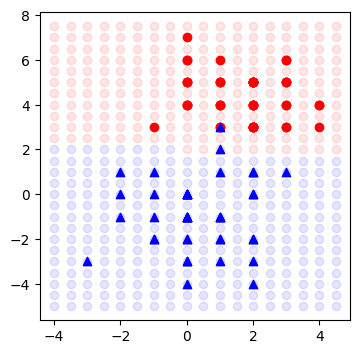

Epoch 20
-------------------------------
loss : 0.04675491792786785


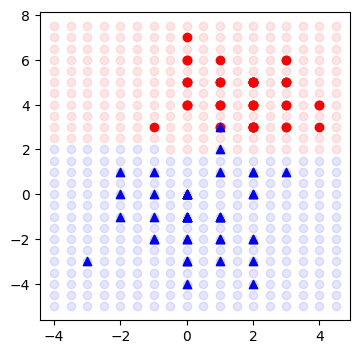

loss : 0.016337022336280236


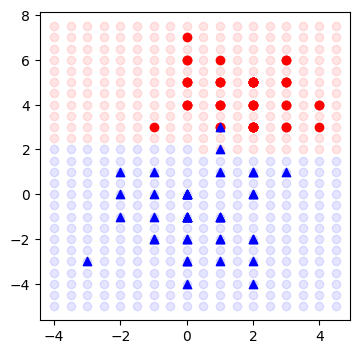

Epoch 21
-------------------------------
loss : 0.045383454058163186


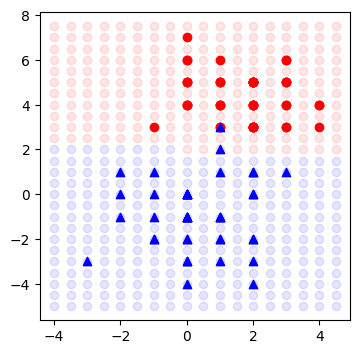

loss : 0.01572058897589568


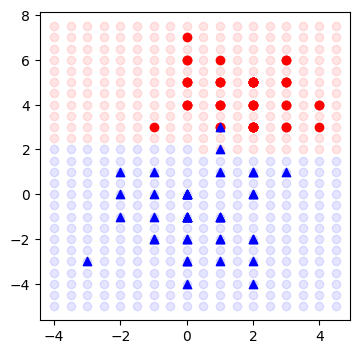

Epoch 22
-------------------------------
loss : 0.044120665687225176


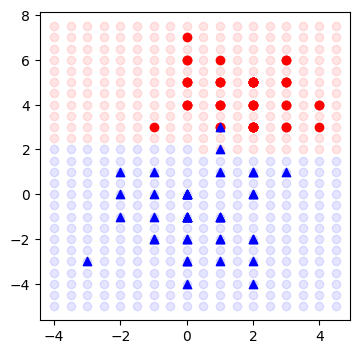

loss : 0.015169556649853304


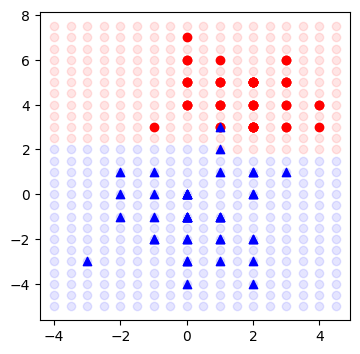

Epoch 23
-------------------------------
loss : 0.04295397627639073


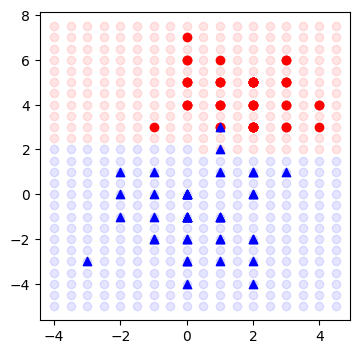

loss : 0.014674997652665457


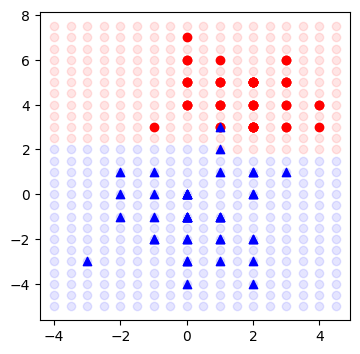

Epoch 24
-------------------------------
loss : 0.041873287509460407


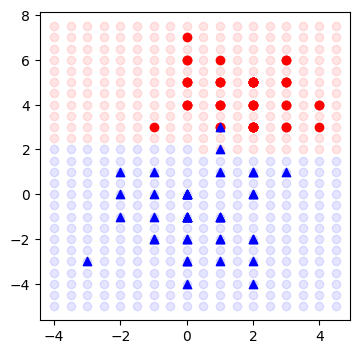

loss : 0.01422953173791707


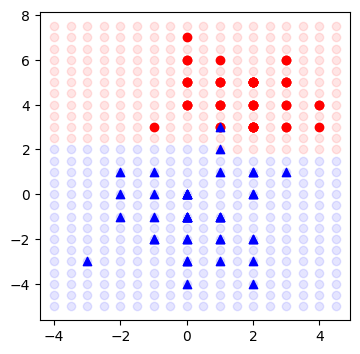

Epoch 25
-------------------------------
loss : 0.040870318967508514


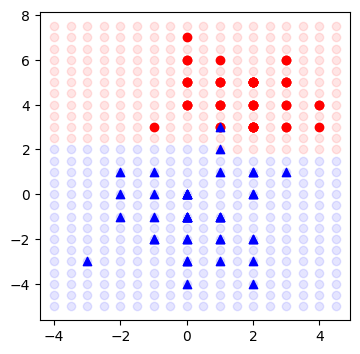

loss : 0.01382699374844896


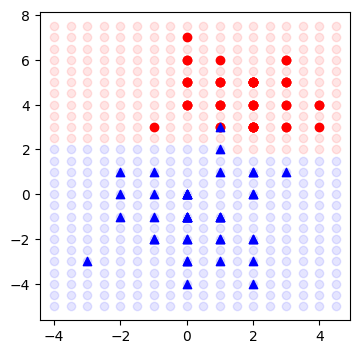

Epoch 26
-------------------------------
loss : 0.03993812507472934


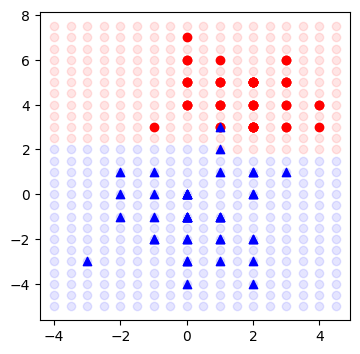

loss : 0.013462184852037467


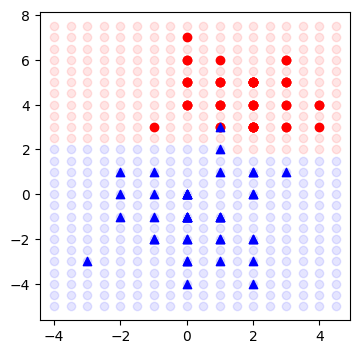

Epoch 27
-------------------------------
loss : 0.039070745777475664


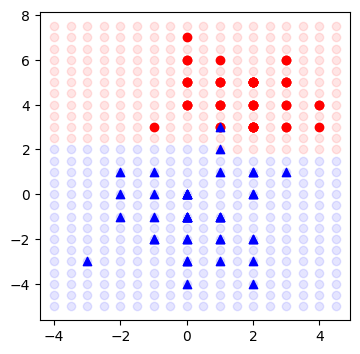

loss : 0.013130684168303406


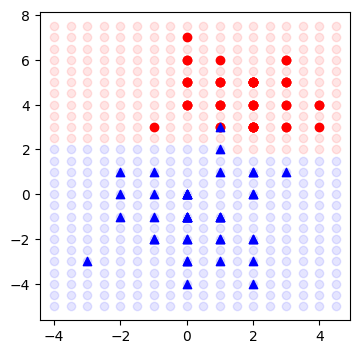

Epoch 28
-------------------------------
loss : 0.03826295791062338


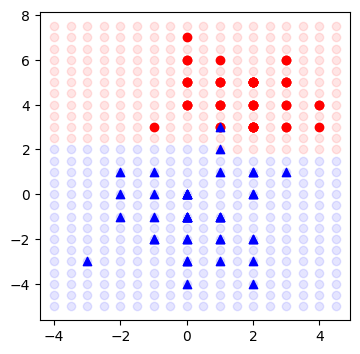

loss : 0.012828704476417199


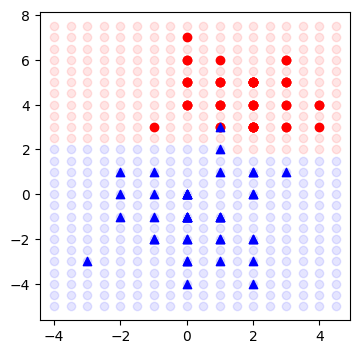

Epoch 29
-------------------------------
loss : 0.037510101459108505


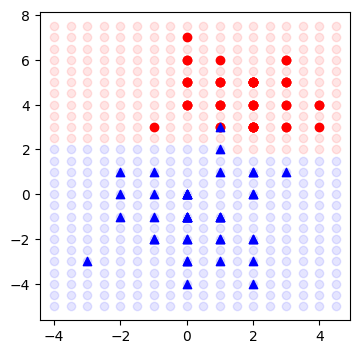

loss : 0.012552980391581295


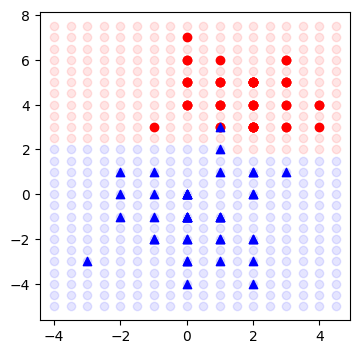

Epoch 30
-------------------------------
loss : 0.03680796038036822


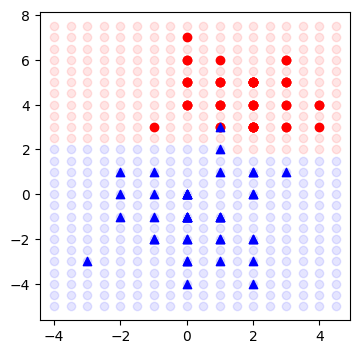

loss : 0.01230068066015414


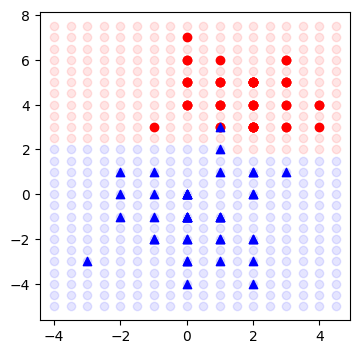

In [63]:
demo_neuron = SimpleDNN(2, 2)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.5, 2)

epochs = 30
m = train_labels.shape[0]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.1)

        if iter_id % (m-1) == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.5, 2)

In [ ]:
def draw_neuron_boundary_2(weights, bias, features, labels, markers, colors):
    # Define the grid of points
    grid_step = 0.5
    xx, yy = np.meshgrid(np.arange(-4, 10, grid_step), np.arange(-4, 10, grid_step))
    grid_points = np.c_[xx.ravel(), yy.ravel()].T

    # Predict
    #predict = neuron.predict(grid_points)
    X = grid_points
    m = X.shape[1]
    b = np.ones((1, m))
    x = np.concatenate((X, b), axis=0)

    # weights bias tensor
    nn_weights = weights.numpy()
    nn_bias = bias.numpy().reshape((1, 1))
    W = np.concatenate((nn_weights.T, nn_bias), axis=0)
    z = W.T.dot(x)
    predict = sigmod(z)

    # Create the scatter plot with decision boundary
    positive_index = np.where(predict[0,:] > 0.5)
    negative_index = np.where(predict[0,:] <= 0.5)

    plt.figure(figsize=(4, 4))
    plt.scatter(grid_points[0, positive_index], grid_points[1, positive_index], c='b', alpha=0.3)
    plt.scatter(grid_points[0, negative_index], grid_points[1, negative_index], c='y', alpha=0.3)

    for i in range(2):
        x = features[0, np.where(labels[i, :] == 1)]
        y = features[1, np.where(labels[i, :] == 1)]
        plt.scatter(x, y, marker=markers[i], c=colors[i])

    plt.show()

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

train_X = torch.Tensor(train_features.T) # transform to torch tensor
train_y = torch.Tensor(train_labels.T)
#print('train_X ', train_X.shape)
#print('train_y ', train_y.shape)
train_dataset = TensorDataset(train_X, train_y)
train_dataloader = DataLoader(train_dataset)
#print('train_dl ', type(train_dataloader.dataset))
#print('train_dl ', len(train_dataloader.dataset))

test_X = torch.Tensor(test_features.T) # transform to torch tensor
test_y = torch.Tensor(test_labels.T)
test_dataset = TensorDataset(test_X, test_y)
test_dataloader = DataLoader(test_dataset)

# Learn to use pytorch to build the same nn to compare with the self-implement NN

class TorchNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features = 2, out_features = 1, bias = True)
        self.A = nn.Sigmoid()
        self.output = nn.Linear(in_features = 1, out_features = 2, bias = True)

    def forward(self, x):
        #print('nn forward, x shape:', x.shape)
        x = self.flatten(x)
        logits = self.output(self.A(self.fc1(x)))

        #print('nn forward, after flatten x shape:', x.shape)
        return logits

    def show_weights(self):
        #print(self.fc1.weight.data, self.fc1.bias.data,  self.output.weight.data, self.output.bias.data)
        return

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            draw_neuron_boundary_2(model.fc1.weight.data, model.fc1.bias.data, train_features, train_labels, markers, colors)
            #model.show_weights()

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


tNN = TorchNN()
print(tNN)

#loss_function = nn.MSELoss()
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(tNN.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, tNN, loss_function, optimizer)
    #tNN.show_weights()
    test_loop(test_dataloader, tNN, loss_function)
print("Done!")




TorchNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2, out_features=1, bias=True)
  (A): Sigmoid()
  (output): Linear(in_features=1, out_features=2, bias=True)
)
Epoch 1
-------------------------------


RuntimeError: ignored